Process the data.

In [2]:
import pandas as pd
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [6]:
def process_df(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    columns = ['Age_categories','Fare_categories','Title','Cabin_type', 'Sex']
    for col in columns:
        df = create_dummies(df, col)
    return df

In [7]:
train = process_df(train)
holdout = process_df(holdout)

Explore the data.

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

train['SibSp'].describe()

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64

In [16]:
train['Parch'].describe()

count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64

In [21]:
train['relatives'] = train['SibSp']+train['Parch']
train['relatives'].describe()

count    891.000000
mean       0.904602
std        1.613459
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       10.000000
Name: relatives, dtype: float64

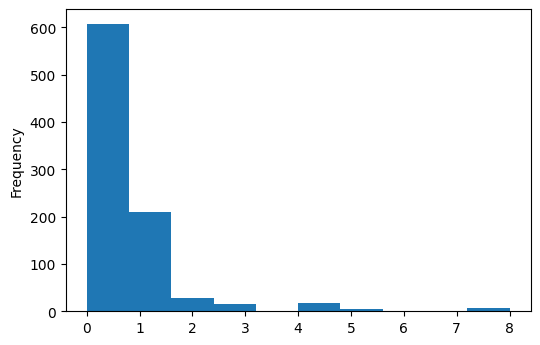

In [13]:
train['SibSp'].plot.hist()
plt.show()

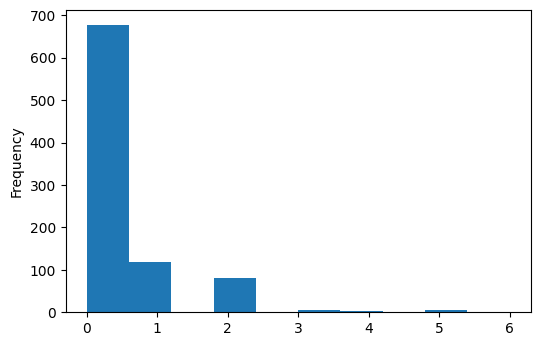

In [17]:
train['Parch'].plot.hist()
plt.show()

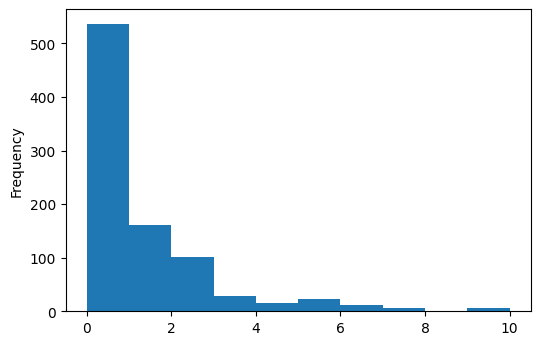

In [22]:
train['relatives'].plot.hist()
plt.show()

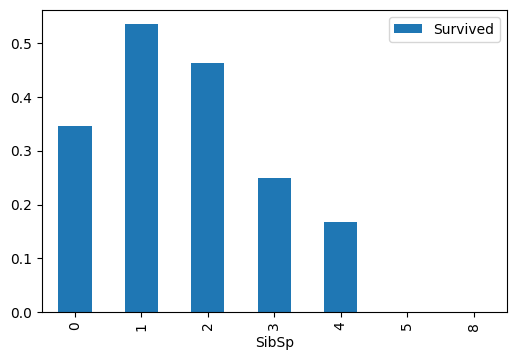

In [15]:
SibSp_pivot = train.pivot_table(index='SibSp',values='Survived')
SibSp_pivot.plot.bar()

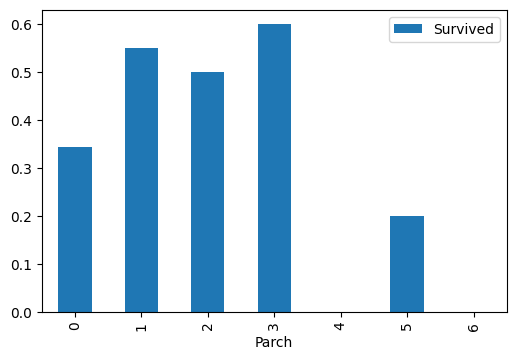

In [23]:
Parch_pivot = train.pivot_table(index='Parch',values='Survived')
Parch_pivot.plot.bar()

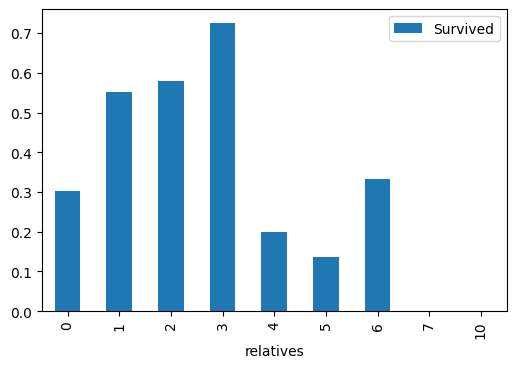

In [24]:
rel_pivot = train.pivot_table(index='relatives',values='Survived')
rel_pivot.plot.bar()

It might be worth using the relatives feature, and binning it according to 'solo', 'between 1 and 3 relatives' and 'more than 3 relatives'. The guided project suggests coding whether or not the passanger was alone first, so let's explore that first.

In [25]:
def process_isalone(df):
    df['relatives'] = df['SibSp']+df['Parch']
    df['isalone'] = [0 if x == 0 else 1 for x in df['relatives']]
    return df

In [27]:
train = process_isalone(train)
holdout = process_isalone(holdout)

Feature selection

In [29]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    df = df.select_dtypes(include='number').dropna(axis=1)
    all_X = df.drop(['PassengerId','Survived'], axis=1)
    all_y = df['Survived']
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X, all_y)
    optimized_columns = all_X.columns[selector.support_]
    return optimized_columns

In [30]:
best_columns = select_features(train)
best_columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Fare_categories_0-12', 'Fare_categories_12-50',
       'Fare_categories_50-100', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'relatives', 'isalone'],
      dtype='object')

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    dict_list = [
        {
            'name': 'LogisticRegression',
            'estimator': LogisticRegression(),
            'hyperparameters':
            {
                'solver': ['newton-cg', 'lbfgs', 'liblinear']
            }
        },
        {
            'name': 'KNeighborsClassifier',
            'estimator': KNeighborsClassifier(),
            'hyperparameters':
            {
                'n_neighbors': range(1,20,2),
                'weights': ['distance', 'uniform'],
                'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                'p': [1,2]
            }
        },
        {
            'name': 'RandomForestClassifier',
            'estimator': RandomForestClassifier(),
            'hyperparameters':
            {
                'n_estimators': [4,6,9],
                'criterion': ['entropy', 'gini'],
                'max_depth': [2,5,10],
                'max_features': ['log2', 'sqrt'],
                'min_samples_leaf': [1,5,8],
                'min_samples_split': [2,3,5]
            }
        }
    ]
    for d in dict_list:
        print(d['name'])
        grid = GridSearchCV(d['estimator'], 
                            param_grid=d['hyperparameters'],
                           cv=10)
        grid.fit(all_X, all_y)
        d['best_params'] = grid.best_params_
        d['best_score'] = grid.best_score_
        d['best_estimator'] = grid.best_estimator_
        print('Best parameters: ', d['best_params'])
        print('Best score: ', d['best_score'])
    return dict_list

In [32]:
best_model = select_model(train, best_columns)

LogisticRegression


/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/dataquest/s

Best parameters:  {'solver': 'newton-cg'}
Best score:  0.821585518102372
KNeighborsClassifier
Best parameters:  {'algorithm': 'kd_tree', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best score:  0.7811485642946318
RandomForestClassifier
Best parameters:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 6}
Best score:  0.8440449438202247


[{'name': 'LogisticRegression',
  'estimator': LogisticRegression(),
  'hyperparameters': {'solver': ['newton-cg', 'lbfgs', 'liblinear']},
  'best_params': {'solver': 'newton-cg'},
  'best_score': 0.821585518102372,
  'best_estimator': LogisticRegression(solver='newton-cg')},
 {'name': 'KNeighborsClassifier',
  'estimator': KNeighborsClassifier(),
  'hyperparameters': {'n_neighbors': range(1, 20, 2),
   'weights': ['distance', 'uniform'],
   'algorithm': ['ball_tree', 'kd_tree', 'brute'],
   'p': [1, 2]},
  'best_params': {'algorithm': 'kd_tree',
   'n_neighbors': 3,
   'p': 1,
   'weights': 'uniform'},
  'best_score': 0.7811485642946318,
  'best_estimator': KNeighborsClassifier(algorithm='kd_tree', n_neighbors=3, p=1)},
 {'name': 'RandomForestClassifier',
  'estimator': RandomForestClassifier(),
  'hyperparameters': {'n_estimators': [4, 6, 9],
   'criterion': ['entropy', 'gini'],
   'max_depth': [2, 5, 10],
   'max_features': ['log2', 'sqrt'],
   'min_samples_leaf': [1, 5, 8],
   'min

Submit to Kaggle

In [33]:
def save_submission_file(model, features, filename='submission.csv'):
    holdout_predictions = model.predict(holdout[features])
    submission = pd.DataFrame({
        'PassengerId':holdout['PassengerId'],
        'Survived':holdout_predictions
    })
    submission.to_csv(filename, index=False)

In [34]:
best_clf_model = best_model[2]['best_model']
save_submission_file(best_rf_model,best_columns)

KeyError: 'best_model'